__Author:__ Bogdan Bintu

__Email:__ bbintu@g.harvard.edu

__Date:__ 3/4/2020

### Segment DAPI images

In [1]:
import sys,cv2,os,glob
import tifffile
sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm_notebook as tqdm
import scipy.ndimage as ndi
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.segmentation import random_walker
from scipy.spatial.distance import cdist
import matplotlib.pylab as plt

In [ ]:
### usefull functions
def get_frame(dax_fl,ind_z=1,sx=2048,sy=2048):
    "returns single frame of a dax file at frame ind_z"
    f = open(dax_fl, "rb")
    bytes_frame = sx*sy*2
    f.seek(bytes_frame*ind_z)
    im_ = np.fromfile(f,dtype=np.uint16,count=sx*sy).reshape([sx,sy]).swapaxes(0,1)
    f.close()
    return im_
def im2d_to_infocus(im_,bs = 11,mbs=7,th_b = 1.6,th_s = 0.15,plt_val=False):
    """Takes a 2d image and thresholds it based on the level of the signal and the local standard deviation of the sinal
    This is used to threshold image prior to cell segmentation.
    """
    im_sq_blur = cv2.blur(im_*im_,(bs,bs))
    im_blur_sq = cv2.blur(im_,(bs,bs))
    im_blur_sq *=im_blur_sq
    im_std = np.sqrt(im_sq_blur - im_blur_sq)
    
    im__ = (im_std<th_s)&(im_<th_b)
    im_in = np.array(1-im__,dtype=np.uint8)
    im_in = cv2.medianBlur(im_in,mbs)
    
    if plt_val:
        plt.figure()
        plt.plot(im_std.ravel(),im_.ravel(),'o',alpha=0.01)
        plt.show()
        plt.figure(figsize=(15,15))
        plt.imshow(im_,cmap='gray')
        plt.contour(im_in,[0.5],colors=['r'])
        plt.show()
    return im_in

In [7]:
master_folder=r'\\10.245.74.218\Raw_data\Bogdan\7_27_2019_IMR90RNA'
analysis_folder = master_folder+'-Analysis'
analysis_folder = analysis_folder+os.sep+'_CellSegm_Analysis'
if not os.path.exists(analysis_folder):
    os.makedirs(analysis_folder)
H0_folder = glob.glob(master_folder+os.sep+'H*B,B')[0]
dax_files = glob.glob(H0_folder+os.sep+'*.dax')

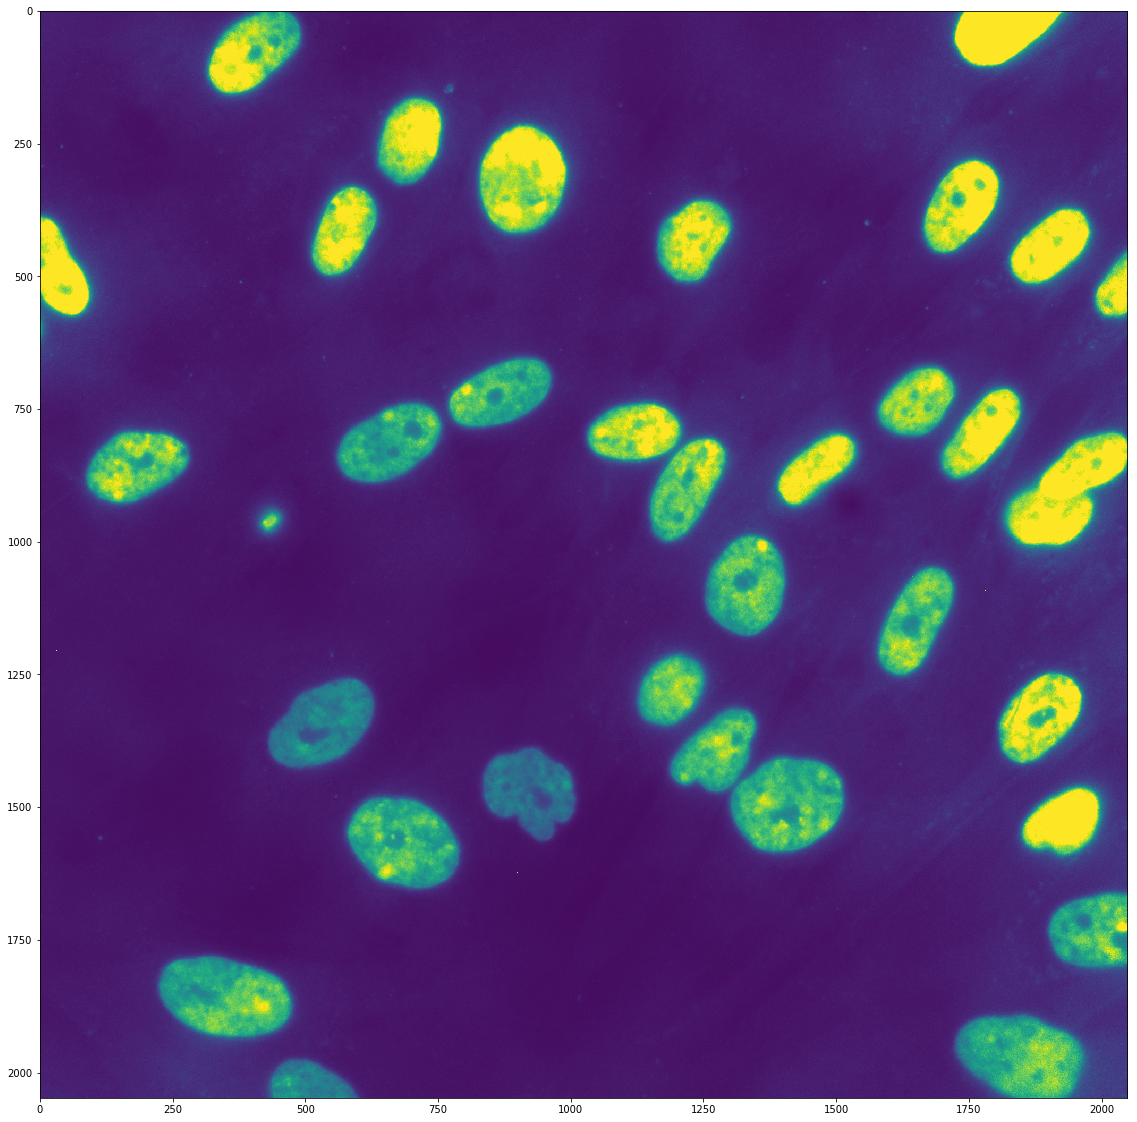

In [26]:
### Check a frame of a field of view
dapi_mean = np.load(analysis_folder+os.sep+'dapi_mean.npy')
dax_file = dax_files[60]
im = get_frame(dax_file,ind_z=5*45-1)

im=im/dapi_mean
plt.figure(figsize=(20,20))
plt.imshow(im,vmax=6)
plt.show()

### Check paramaters for initial thresholding

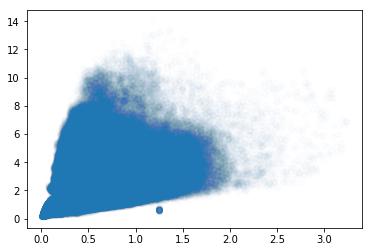

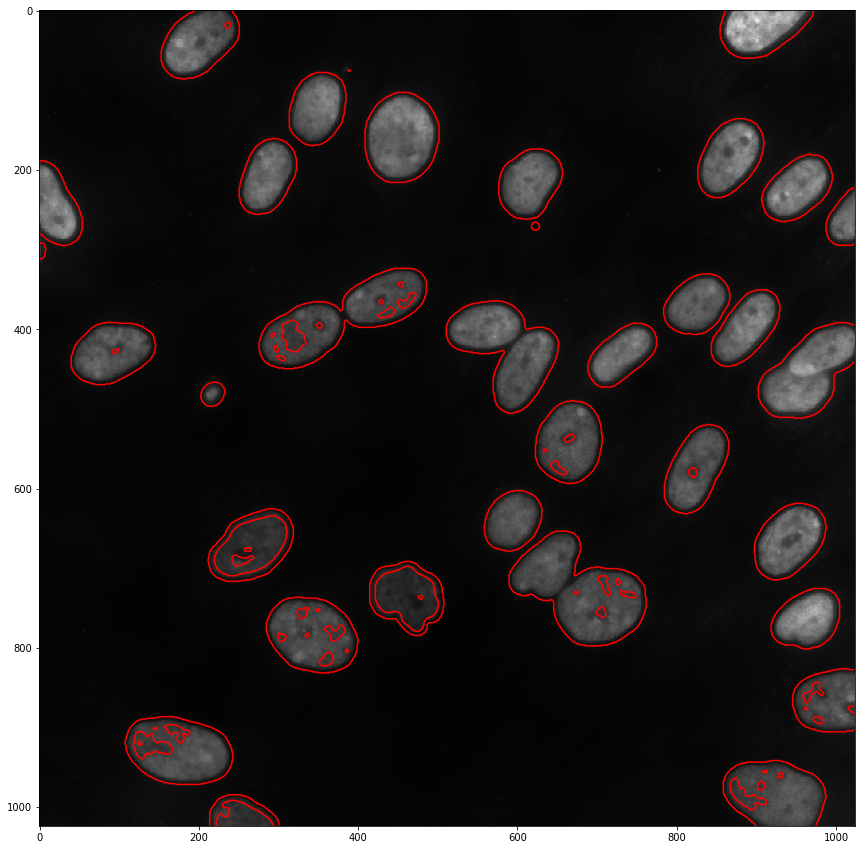

In [29]:
im_in = im2d_to_infocus(im[::2,::2],bs = 10,mbs=7,th_b = 3.5,th_s = 0.4,plt_val=True)

### Core functions for cell segmentation 

In [63]:
def cast_uint8(im,min_=None,max_=None):
    im_ = np.array(im,dtype=np.float32)
    if min_ is None: min_ = np.min(im)
    if max_ is None: max_ = np.max(im)
    delta = max_-min_
    if delta==0: delta =1
    im_ = (im-min_)/delta
    im_ = (np.clip(im_,0,1)*255).astype(np.uint8)
    return im_
def save_3dSegmentation_tif(im_base,imcells3d,imcells3d_lims,save_file,min_=0,max_=2):
    im_overlay = cast_uint8(im_base,min_=min_,max_=max_)
    im_overlay = np.array([im_overlay,im_overlay,im_overlay]).swapaxes(0,-1).swapaxes(0,1).swapaxes(1,2)

    for index in range(len(imcells3d_lims)):
        zm,zM,xm,xM,ym,yM = imcells3d_lims[index]
        imcells3d_red =  imcells3d[zm:zM,xm:xM,ym:yM]==index+1
        for zmed in range(zM-zm):
            if zmed<len(imcells3d_red):
                im_2d = imcells3d_red[zmed]
                cont_results = cv2.findContours(im_2d.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contour = cont_results[0]#np.squeeze()
                #print contour,cont_results
                if len(contour)>0:
                    base_im = np.zeros([xM-xm,yM-ym,3],dtype = np.uint8)
                    cont_im = cv2.polylines(base_im, contour,1, (128,0,0),2)
                    xs,ys = np.where(im_2d)
                    cm = (int(np.mean(ys)),int(np.mean(xs)))
                    cv2.putText(cont_im,str(index+1),cm, 
                                cv2.FONT_HERSHEY_SIMPLEX,0.33,(0,255,255),1,cv2.LINE_AA)
                    im_overlay_ = im_overlay[zm+zmed,xm:xM,ym:yM]

                    im_overlay[zm+zmed,xm:xM,ym:yM] = np.clip(im_overlay_+cont_im*1.,0,255).astype(np.uint8)
    tifffile.imwrite(save_file,im_overlay,compress=0)

def segment_daxfl(dax_file,save_file):
    print("Loading:",dax_file)
    im = get_frame(dax_file,ind_z=5*45-1)
    im=im/dapi_mean
    im_mask_2d = im2d_to_infocus(im[::2,::2],bs = 10,mbs=7,th_b = 3.5,th_s = 0.4,plt_val=False)
    #im_mask = np.swapaxes(im_mask,0,1)
    #im_mask = np.array([cv2.medianBlur(im_,11) for im_ in im_mask ])
    #im_mask_2d = np.max(im_mask,0)>0
    im_mask_2d = ndi.binary_fill_holes(im_mask_2d>0)
    dist = ndi.distance_transform_edt(im_mask_2d) #distance transformation for watershed
    local_max = peak_local_max(dist, indices = False, min_distance=20)
    x,y = np.where(local_max)
    X=np.array([x,y]).T
    distM = cdist(X,X)
    distM[range(len(X)),range(len(X))]=np.inf
    xp,yp = np.where(distM<30)
    ik=np.setdiff1d(np.arange(len(x)),xp[xp>yp])
    x,y = x[ik],y[ik]
    local_max = 0*im_mask_2d
    local_max[np.array(x,dtype=int),np.array(y,dtype=int)]=1
    markers = ndi.label(local_max)[0]
    markers[im_mask_2d==0] = -1
    labeled_dapi = random_walker(im_mask_2d, markers)
    labeled_dapi[labeled_dapi==-1]=0

    im_temp = np.array(labeled_dapi)
    xs,ys = np.where(im_temp>0)
    delta = 1
    bad = (xs<delta)|(xs>=im_temp.shape[0]-delta)|(ys<delta)|(ys>=im_temp.shape[1]-delta)
    bad_inds = np.unique(im_temp[xs[bad],ys[bad]])
    for ind in bad_inds:
        im_temp[im_temp==ind]=0

    #labeled_nuc, num_nuc = ndi.label(im)
    inds = np.unique(im_temp)[1:]
    im_ = np.array(im_temp)
    ct = 0
    for iind,ind in enumerate(inds):
        kp = im_==ind
        area = np.sum(kp)
        if area>2000:
            ct+=1
            im_temp[kp]=ct
        else:
            im_temp[kp]=0
    im = np.array([im])
    imcells3d = np.array([im_temp]*len(im),dtype=np.uint16)
    
    np.save(save_file,imcells3d)
    
    imcells3d_lims = []
    pad = 20
    for celli in np.unique(im_temp)[1:]:
        x,y = np.where(im_temp==celli)
        xm,xM,ym,yM = np.min(x)-pad,np.max(x)+pad,np.min(y)-pad,np.max(y)+pad
        zm,zM = 0,len(im)
        if xM>im_temp.shape[0]:xM=im_temp.shape[0]-1
        if yM>im_temp.shape[1]:yM=im_temp.shape[1]-1
        if xm<0:xm=0
        if ym<0:ym=0
        imcells3d_lims.append([zm,zM,xm,xM,ym,yM])
    imcells3d_lims = np.array(imcells3d_lims)
    np.save(save_file.replace('__imcells2d.npy','__imcells2d_lims.npy'),imcells3d_lims)
    save_3dSegmentation_tif(im[:,::2,::2],imcells3d,imcells3d_lims,save_file.replace('__imcells2d.npy','__2dshow.tif'),
                           min_=0,max_=8)

### Run cell segmentation

In [ ]:
dax_files = np.sort(dax_files)
for dax_file in tqdm(dax_files[:]):
    save_file  = analysis_folder+os.sep+os.path.basename(dax_file).replace('.dax','__imcells2d.npy')
    segment_daxfl(dax_file,save_file)
    #break

In [71]:
dax_file,save_file

('\\\\10.245.74.218\\Raw_data\\Bogdan\\7_27_2019_IMR90RNA\\H0B,B\\Conv_zscan_69.dax',
 '\\\\10.245.74.218\\Raw_data\\Bogdan\\7_27_2019_IMR90RNA-Analysis\\_CellSegm_Analysis\\Conv_zscan_69__imcells2d.npy')

### Perform manual correction to automatic cell segmentaion

In [ ]:
import os,glob,sys
import numpy as np
import cPickle as pickle
from tqdm import tqdm_notebook as tqdm
import scipy.ndimage as ndi
from scipy.spatial.distance import cdist
import matplotlib.pylab as plt

import cv2
import IOTools as io

#### Make and write a png file with the automatic mask in one channel and the DAPI signal in another by concatenating across all fields of view

In [73]:
dapiSeg = r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis\_CellSegm_Analysis'
seg_fls = np.sort(glob.glob(dapiSeg+os.sep+'*__imcells2d.npy'))
dapiFolder = r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA\H0B,B'

im_comps = []
for seg_fl in tqdm(seg_fls):
    dapi_fl = dapiFolder+os.sep+os.path.basename(seg_fl).replace('__imcells2d.npy','.dax')
    im_mask = np.load(seg_fl)[0].T
    nmax = np.max(im_mask)+1
    im_edge = np.zeros_like(im_mask)
    for iobj in range(1,nmax):
        im_mask_ = (im_mask==iobj).astype(np.uint8)
        kernel = np.ones([3,3],dtype=np.uint8)#cv2.getStructuringElement(cv2.MORPH_OPEN,(4,4))
        im_erode = cv2.erode(im_mask_,kernel)
        im_edge += im_mask_-im_erode
    imf = (1-(im_edge>0))*(im_mask>0)
    im = np.array(io.DaxReader(dapi_fl).loadMap()[5*45-1][::2,::2],dtype=np.float32)
    im_dapi = im/np.max(im)
    im_comp = np.dstack([imf*0,im_dapi,imf*0.5])
    im_comps.append(im_comp)
    
    #plt.figure()
    #plt.imshow(im_comp)
    #plt.show()
    #break

In [74]:
cv2.imwrite(r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis\_CellSegm_Analysis\all_masks.png',
            (np.concatenate(im_comps,axis=0)*255).astype(np.uint8))

True

### Refine the _allmask_ file in Photoshop to correct missegmentation and then load it in

In [83]:
im = cv2.imread(r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis\_CellSegm_Analysis\all_masks.tif')

In [625]:
%matplotlib inline

### Restructure refined mask and save for each field of view

In [86]:
im_mask = im[:,:,-1].reshape([-1,1024,1024])
nlabtot=0
dapi_fls = np.sort(glob.glob(r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA\H0B,B\*.dax'))
save_folder = r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis\_CellSegm_Analysis\cnn_segmentation'
if not os.path.exists(save_folder):os.makedirs(save_folder)
for im_m,dax_file in tqdm(zip(im_mask,dapi_fls)):
    #print("Loading:",dax_file)
    save_file  = save_folder+os.sep+os.path.basename(dax_file).replace('.dax','__imcells3d.npy')
    im_dapi = io.DaxReader(dax_file).loadMap()
    im_dapi = im_dapi[:-10][4::5][2:]
    nz = len(im_dapi)
    im_dapi = np.array(im_dapi[int(nz/2)])
    
    im_ = np.array(im_m>100,dtype=np.uint8)
    nlab,imlab,res,centers = cv2.connectedComponentsWithStats(im_)
    im_temp = imlab.copy()
    inds = np.unique(im_temp)[1:]
    im_ = np.array(im_temp)
    ct = 0
    for iind,ind in enumerate(inds):
        kp = im_==ind
        area = np.sum(kp)
        if area>100:
            ct+=1
            im_temp[kp]=ct
        else:
            im_temp[kp]=0
    imlab = im_temp
    
    imcells3d = np.array([imlab]*nz,dtype=np.uint16)
    np.save(save_file,imcells3d)
    imcells3d_lims = []
    pad = 20
    
    for celli in np.unique(imlab)[1:]:
        x,y = np.where(imlab==celli)
        xm,xM,ym,yM = np.min(x)-pad,np.max(x)+pad,np.min(y)-pad,np.max(y)+pad
        zm,zM = 0,len(im)-1
        if xM>imlab.shape[0]:xM=imlab.shape[0]-1
        if yM>imlab.shape[1]:yM=imlab.shape[1]-1
        if xm<0:xm=0
        if ym<0:ym=0
        imcells3d_lims.append([zm,zM,xm,xM,ym,yM])
    imcells3d_lims = np.array(imcells3d_lims)
    np.save(save_file.replace('__imcells3d.npy','__imcells3d_lims.npy'),imcells3d_lims)
    fig = plt.figure(figsize=(10,10))
    plt.contour(im_,[0.5],colors=['r'])
    plt.imshow(im_dapi[::2,::2])
    fig.savefig(save_file.replace('.npy','.png'))
    plt.close()
    #break

### Fit the signal per each cell per each filed of view. Also use the bead data to align.

In [ ]:
#Turn on clusters
#Open terminal and run: ipcluster start -n 20
import ipyparallel as ipp
from ipyparallel import Client
rc = Client()
def f(index):
    import sys
    sys.path.append(r'C:\Users\bogdan\code_seurat\WholeGenome_MERFISH')
    import workers_cells_v2 as wkc
    reload(wkc)
    try:
        obj = wkc.cell_focus(index_fov=index,dataset_tag='7_27_2019_IMR90RNA',
                   parent_dapiSeg=r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis\_CellSegm_Analysis',
                  parent_fits_analysis=r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis',
                  parent_save = r'E:\Bogdan_Temp\7_27_2019_IMR90RNA-Analysis-refitted',
                  fl_750_647 = r'\\dolly\Raw_data\Bogdan\ChromaticAberation_STORM6\dic_chr_150nm_IMR90_v2.pkl',#
                  fl_750_561 = r'\\dolly\Raw_data\Bogdan\ChromaticAberation_STORM6\dic_chr_150nm_IMR90_v2.pkl',#
                  RNA_dapi_tag = 'H0B,B',
                  overwrite=False)
    
        if not obj.is_complete():
            obj.z_cutoff=5
            obj.pad=10
            obj.master_folder=r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA'
            obj.apply_to_pfits()
            obj.save()
        success = True
    except:
        success = False
    return success

In [ ]:
res = rc[:].map_sync(f,range(70)) #70 indicates the number of field of views

### Decoding Analysis

In [56]:
%matplotlib inline

#### Load all the fitted data per cell across all cells

In [55]:
import glob,os,sys
import numpy as np
import workers_cells_v3 as wkc
import PostFitting as pf
reload(pf)
reload(wkc)
#files = np.sort(glob.glob(r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis\cell_dics\*_cells.npy'))
files = np.sort(glob.glob(r'E:\Bogdan_Temp\7_27_2019_IMR90RNA-Analysis-refitted\cell_dics\*_cells.npy'))
cell_obj = wkc.cell_analysis(files[:])#,5,6,7,8
cell_obj.normalize_cell_dic()

Best picks: ['Q22', 'Q23', 'Q24', 'Q40_rep1', 'Q41_rep1', 'Q42_rep1', 'R3', 'R5_rep1', 'R80_rep1']
Q40_rep1 Q40
Q41_rep1 Q41
Q42_rep1 Q42
R5_rep1 R5
R80_rep1 R80


#### Check drift errors acros field of views

In [ ]:
### Check drift errors
fovs = np.sort(cell_obj.dic_noncells.keys())
for fov in fovs:
    cell_obj.dic_noncell = cell_obj.dic_noncells[fov]
    errors,drifts = [],[]
    for i in range(100):
        errors.append(cell_obj.dic_noncell['drift_errors']['R'+str(i+1)])
        drifts.append(cell_obj.dic_noncell['dic_drift_final']['R'+str(i+1)][0][:,0])
    errors,drifts =np.array(errors),np.array(drifts)
    plt.figure()
    plt.title(fov+'-Drift-error')
    plt.plot(errors[:,0])
    plt.plot(errors[:,1])
    plt.plot(errors[:,2])
    plt.ylim([0,1])
    plt.figure()
    plt.title(fov+'-Drift')
    plt.plot(drifts[:,0])
    plt.plot(drifts[:,1])
    plt.plot(drifts[:,2])
    plt.show()

### Test decoding per one cell

Conv_zscan_18__cell10
0.0830622967225 0.908741594621
0.8535062439961575
0.9414024975984631 0.9365994236311239
0.8554274735830932
0.9452449567723343 0.9558117195004803
0.8155619596541787
('Number of RNA:', 230)


NameError: name 'plt' is not defined

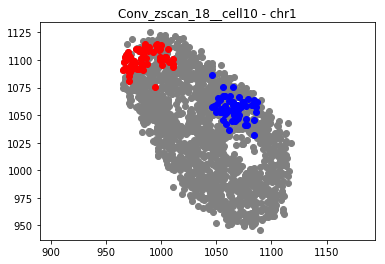

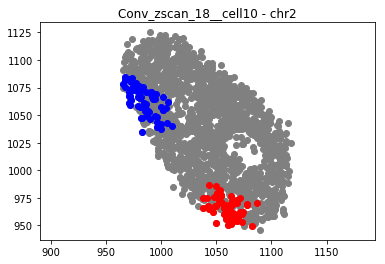

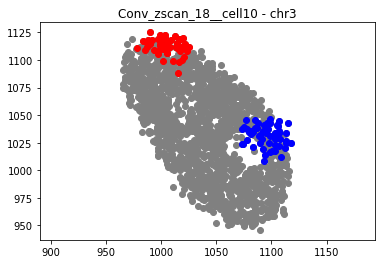

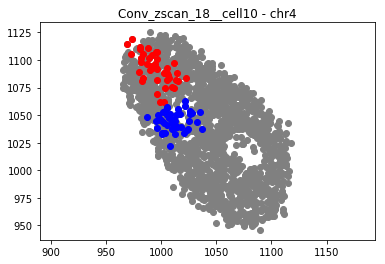

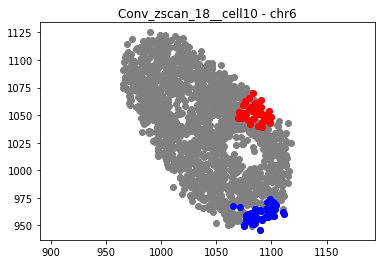

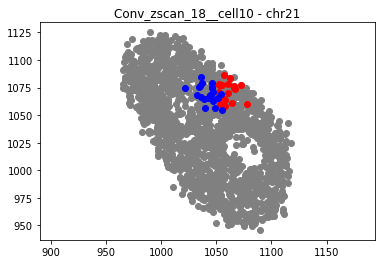

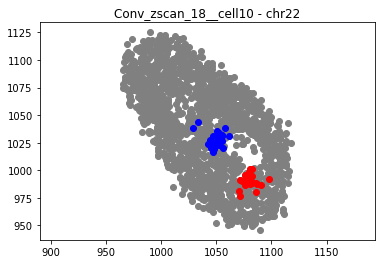

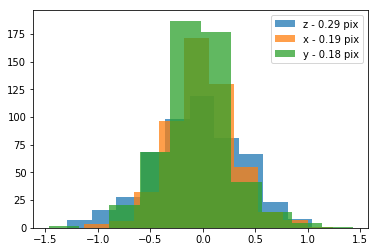

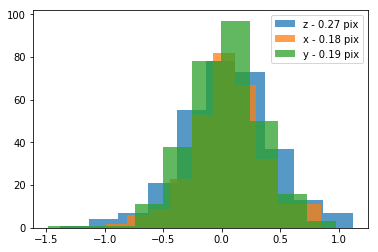

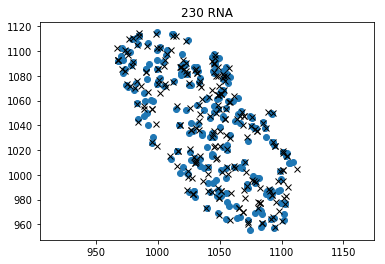

In [57]:
reload(wkc)

###Load a cell from the dataset i.e. cell 95
cell_obj.set_cell(95)
print cell_obj.cell

#decide whether to apply a different chromatic abberation correction
if False:
    fl = r'\\dolly\Raw_data\Bogdan\ChromaticAberation_STORM6\dic_chr_150nm_IMR90_v2.pkl'
    dic_chr = np.load(fl)
    ms_chr = [None,dic_chr['m_750_647'],dic_chr['m_750_561']]
    cell_obj = wkc.update_color(cell_obj,ms_chr)

########## DNA ####################
#load the DNA code
cell_obj.load_DNA_code()
#get a list of candidates that are roughly in the correct ~200nm threshold
cell_obj.get_candidates(cutoff_candidate = [2.25,1.75,1.75],cap_invalid = 4000)
cell_obj.get_main_scores()
cell_obj.get_th_bleed(nkeep=2,plt_val=False)
cell_obj.get_chr_points()

cell_obj.get_chr_trees()
cell_obj.enhance_scores_1(nneigh=15)
cell_obj.get_th_bleed(nkeep=2,plt_val=False)
cell_obj.get_chr_points()
print cell_obj.bleed_score,cell_obj.coverage

#separate into homologs
#cell_obj.get_homolog_centers_single(ichr_ = 1,plt_val=True)
cell_obj.get_homolog_centers()
cell_obj.enhance_scores_2(ihom=0)
cell_obj.Distrib1,cell_obj.DsCC1 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
cell_obj.get_th_bleed(nkeep=1,plt_val=False)
cell_obj.th_score1,cell_obj.scores_valid1 = cell_obj.th_score,cell_obj.scores_valid[:]
cell_obj.enhance_scores_2(ihom=1,Distrib=cell_obj.Distrib1)
cell_obj.Distrib2,cell_obj.DsCC2 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
cell_obj.get_th_bleed(nkeep=1,plt_val=False)
cell_obj.th_score2,cell_obj.scores_valid2 = cell_obj.th_score,cell_obj.scores_valid[:]
cell_obj.get_chr_points_homologs()

def compare(pts1,pts2,nan=True):
    good_num,all_num = 0,0
    for pts1_chr,pts2_chr in zip(pts1,pts2):
        pts1_chr,pts2_chr=np.array(pts1_chr),np.array(pts2_chr)
        if nan:
            pts1_chr[np.isnan(pts1_chr)]=np.inf
            pts2_chr[np.isnan(pts2_chr)]=np.inf
        good_num+=np.sum(np.all(pts1_chr==pts2_chr,axis=-1))
        all_num+=len(pts1_chr)
    return good_num/float(all_num)
print compare(cell_obj.points1+cell_obj.points2,cell_obj.points1+cell_obj.points2,nan=False)
for irep in range(2):
    cell_obj.enhance_scores_2(ihom=0,Distrib=cell_obj.refined_Distr)
    cell_obj.Distrib1,cell_obj.DsCC1 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
    cell_obj.get_th_bleed(nkeep=1,plt_val=False)
    cell_obj.th_score1,cell_obj.scores_valid1 = cell_obj.th_score,cell_obj.scores_valid[:]
    cell_obj.enhance_scores_2(ihom=1,Distrib=cell_obj.refined_Distr)
    cell_obj.Distrib2,cell_obj.DsCC2 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
    cell_obj.get_th_bleed(nkeep=1,plt_val=False)
    cell_obj.th_score2,cell_obj.scores_valid2 = cell_obj.th_score,cell_obj.scores_valid[:]
    cell_obj.points1_prev,cell_obj.points2_prev = cell_obj.points1,cell_obj.points2
    cell_obj.get_chr_points_homologs()
    print compare(cell_obj.points1_prev,cell_obj.points1),compare(cell_obj.points2_prev,cell_obj.points2)
    print compare(cell_obj.points1+cell_obj.points2,cell_obj.points1+cell_obj.points2,nan=False)
#plot a few positions
for chri in [0,1,2,3,5,20,21]:
    fig = cell_obj.plot_chr(chri=chri,ax1=1,ax2=2)
    #fig.savefig(save_base+'__chri'+str(chri)+'.png')
cell_obj.plot_cell_chromatic_difference(col_check = [1,0])
cell_obj.plot_cell_chromatic_difference(col_check = [0,1])

########## RNA ####################
cell_obj.clean_Qs(h_cutoff=4.,zxy_cutoff=1.5)
for key in cell_obj.dic_cell:
    if 'Q' in key:
        cell_obj.dic_cell[key] = cell_obj.dic_cell[key][:50]
cell_obj.load_RNA_code()
cell_obj.get_candidates(cutoff_candidate = [2.25,1.75,1.75],cap_invalid = 4000)
#rough RNA
dna_zxy,rna_zxy,ps_rna,dna_loc,rna_names,rna_iqs,fig = cell_obj.get_dna_rna_pts(drift=[0,0,0],cutoff_dist=15,plt_val=False)
#print(len(rna_zxy))
#fine RNA
drift = np.nanmedian(rna_zxy-dna_zxy,axis=0)
dna_zxy,rna_zxy,ps_rna,dna_loc,rna_names,rna_iqs,fig = cell_obj.get_dna_rna_pts(drift=drift,cutoff_dist=10.,plt_val=True)
print("Number of RNA:",len(rna_zxy))
#cell_obj.get_main_scores()
#cell_obj.get_th_bleed(nkeep=1,plt_val=True)
ps_pairs_final = [[[cell_obj.ps_pairs_valid_keep1[iv],cell_obj.ps_pairs_valid_keep2[iv]]
                   for iv in ichrs]
                  for ichrs in cell_obj.chr_ivs]
dic_save = {'dna_ps_pairs':ps_pairs_final,'dna_zxy':[cell_obj.points1,cell_obj.points2]}
dic_save.update({'dna_fromRNA_zxy':dna_zxy,'rna_zxy':rna_zxy,
                 'ps_rna':ps_rna,'dna_fromRNA_loc':dna_loc,'rna_names':rna_names,
                'rna_dna_drift':drift,'cell':cell_obj.cell,'dna_refined_Distr':cell_obj.refined_Distr})


### Run across all data

In [59]:
def analyze_cells(list_cells=None):
    import glob,os,sys
    import numpy as np
    sys.path.append(r'C:\Users\bogdan\code_seurat\WholeGenome_MERFISH')
    import workers_cells_v2 as wkc
    import PostFitting as pf
    reload(pf)
    reload(wkc)
    from tqdm import tqdm_notebook as tqdm
    import matplotlib.pylab as plt
    import cPickle as pickle
    success=True
    #Load all the data
    #files = np.sort(glob.glob(r'\\dolly\Raw_data\Bogdan\7_27_2019_IMR90RNA-Analysis\cell_dics\*_cells.npy'))
    files = np.sort(glob.glob(r'E:\Bogdan_Temp\7_27_2019_IMR90RNA-Analysis-refitted\cell_dics\*_cells.npy'))
    cell_obj = wkc.cell_analysis(files[:])#,5,6,7,8
    cell_obj.normalize_cell_dic()
    

    master_folder = os.path.dirname(os.path.dirname(files[0]))
    save_folder = master_folder+os.sep+'cell_decoding'
    save_folder = r'E:\Bogdan_Temp'+os.sep+os.path.basename(master_folder)+os.sep+'cell_decoding_refitted2'
    print save_folder
    if not os.path.exists(save_folder): os.makedirs(save_folder)
    overwrite = False
    if list_cells is None: list_cells = range(len(cell_obj.cells))
    
    #remap chromatic abberation
    fl = r'\\dolly\Raw_data\Bogdan\ChromaticAberation_STORM6\dic_chr_150nm_IMR90_v2.pkl'
    dic_chr = np.load(fl)
    ms_chr = [None,dic_chr['m_750_647'],dic_chr['m_750_561']]

    for icell in tqdm(list_cells):
        
        try:
        #if True:
            cell_obj.set_cell(icell)
            
            save_base = save_folder+os.sep+cell_obj.cell
            print save_base
            
            if overwrite or not os.path.exists(save_base+'.pkl'):
            #if True:
                fid=open(save_base+'.new','w')
                fid.close()
                cell_obj = wkc.update_color(cell_obj,ms_chr)
                cell_obj.load_DNA_code()
                cell_obj.get_candidates(cutoff_candidate = [2.25,1.75,1.75],cap_invalid = 4000)
                cell_obj.get_main_scores()
                cell_obj.get_th_bleed(nkeep=2,plt_val=False)
                cell_obj.get_chr_points()

                cell_obj.get_chr_trees()
                cell_obj.enhance_scores_1(nneigh=15)
                cell_obj.get_th_bleed(nkeep=2,plt_val=False)
                cell_obj.get_chr_points()
                print cell_obj.bleed_score,cell_obj.coverage

                #separate into homologs
                #cell_obj.get_homolog_centers_single(ichr_ = 1,plt_val=True)
                cell_obj.get_homolog_centers()
                cell_obj.enhance_scores_2(ihom=0)
                cell_obj.Distrib1,cell_obj.DsCC1 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
                cell_obj.get_th_bleed(nkeep=1,plt_val=False)
                cell_obj.th_score1,cell_obj.scores_valid1 = cell_obj.th_score,cell_obj.scores_valid[:]
                cell_obj.enhance_scores_2(ihom=1,Distrib=cell_obj.Distrib1)
                cell_obj.Distrib2,cell_obj.DsCC2 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
                cell_obj.get_th_bleed(nkeep=1,plt_val=False)
                cell_obj.th_score2,cell_obj.scores_valid2 = cell_obj.th_score,cell_obj.scores_valid[:]
                cell_obj.get_chr_points_homologs()

                def compare(pts1,pts2,nan=True):
                    good_num,all_num = 0,0
                    for pts1_chr,pts2_chr in zip(pts1,pts2):
                        pts1_chr,pts2_chr=np.array(pts1_chr),np.array(pts2_chr)
                        if nan:
                            pts1_chr[np.isnan(pts1_chr)]=np.inf
                            pts2_chr[np.isnan(pts2_chr)]=np.inf
                        good_num+=np.sum(np.all(pts1_chr==pts2_chr,axis=-1))
                        all_num+=len(pts1_chr)
                    return good_num/float(all_num)
                print compare(cell_obj.points1+cell_obj.points2,cell_obj.points1+cell_obj.points2,nan=False)
                for irep in range(2):
                    cell_obj.enhance_scores_2(ihom=0,Distrib=cell_obj.refined_Distr)
                    cell_obj.Distrib1,cell_obj.DsCC1 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
                    cell_obj.get_th_bleed(nkeep=1,plt_val=False)
                    cell_obj.th_score1,cell_obj.scores_valid1 = cell_obj.th_score,cell_obj.scores_valid[:]
                    cell_obj.enhance_scores_2(ihom=1,Distrib=cell_obj.refined_Distr)
                    cell_obj.Distrib2,cell_obj.DsCC2 = cell_obj.DsCC_distr_valid[:],cell_obj.DsCC_valid
                    cell_obj.get_th_bleed(nkeep=1,plt_val=False)
                    cell_obj.th_score2,cell_obj.scores_valid2 = cell_obj.th_score,cell_obj.scores_valid[:]
                    cell_obj.points1_prev,cell_obj.points2_prev = cell_obj.points1,cell_obj.points2
                    cell_obj.get_chr_points_homologs()
                    print compare(cell_obj.points1_prev,cell_obj.points1),compare(cell_obj.points2_prev,cell_obj.points2)
                    print compare(cell_obj.points1+cell_obj.points2,cell_obj.points1+cell_obj.points2,nan=False)
                #plot a few positions
                for chri in [0,1,2,3,5,20,21]:
                    fig = cell_obj.plot_chr(chri=chri,ax1=1,ax2=2)
                    fig.savefig(save_base+'__chri'+str(chri)+'.png')
                cell_obj.plot_cell_chromatic_difference(col_check = [1,0])
                cell_obj.plot_cell_chromatic_difference(col_check = [0,1])

                ########## RNA ####################
                cell_obj.clean_Qs(ih=-7,h_cutoff=4.,zxy_cutoff=1.5)
                for key in cell_obj.dic_cell:
                    if 'Q' in key:
                        cell_obj.dic_cell[key] = cell_obj.dic_cell[key][:50]
                cell_obj.load_RNA_code()
                cell_obj.get_candidates(cutoff_candidate = [1.75,1.75,1.75],cap_invalid = 4000)
                #rough RNA
                dna_zxy,rna_zxy,ps_rna,dna_loc,rna_names,rna_iqs,fig = cell_obj.get_dna_rna_pts(drift=[0,0,0],cutoff_dist=15,plt_val=False)
                #print(len(rna_zxy))
                #fine RNA
                drift = np.nanmedian(rna_zxy-dna_zxy,axis=0)
                dna_zxy,rna_zxy,ps_rna,dna_loc,rna_names,rna_iqs,fig = cell_obj.get_dna_rna_pts(drift=drift,cutoff_dist=10.,plt_val=True)
                fig.savefig(save_base+'_RNA.png')
                print("Number of RNA:",len(rna_zxy))
                #cell_obj.get_main_scores()
                #cell_obj.get_th_bleed(nkeep=1,plt_val=True)
                ps_pairs_final = [[[cell_obj.ps_pairs_valid_keep1[iv],cell_obj.ps_pairs_valid_keep2[iv]]
                                   for iv in ichrs]
                                  for ichrs in cell_obj.chr_ivs]
                dic_save = {'dna_ps_pairs':ps_pairs_final,'dna_zxy':[cell_obj.points1,cell_obj.points2]}
                dic_save.update({'dna_fromRNA_zxy':dna_zxy,'rna_zxy':rna_zxy,
                                 'ps_rna':ps_rna,'dna_fromRNA_loc':dna_loc,'rna_names':rna_names,
                                'rna_dna_drift':drift,'cell':cell_obj.cell,'dna_refined_Distr':cell_obj.refined_Distr})
                plt.close('all')
                pickle.dump(dic_save,open(save_base+'.pkl','wb'))
            
        except:
            print("Failed ",getattr(cell_obj,'cell','None'))
            success=False
    return success

In [60]:
#Turn on clusters
#Open terminal and run: ipcluster start -n 20
import ipyparallel as ipp
from ipyparallel import Client
rc = Client()

In [62]:
nrc = len(rc)
paramaters = range(2000)
paramaters=[paramaters[icl::nrc] for icl in range(nrc)]

In [63]:
res = rc[:].map_sync(analyze_cells,paramaters)

### Get chromatic abberation

In [1508]:
fl = r'\\dolly\Raw_data\Bogdan\ChromaticAberation_STORM65\final_pairs_200nm.pkl'
dic_chr = np.load(fl)
dic_chr_ = {}
zxy_647,zxy_750 = dic_chr['zxy_647_750']*[200/150.,1,1]
dic_chr_['m_750_647'] = ft.calc_color_matrix(zxy_750,zxy_647+[0.5,0,0])
zxy_561,zxy_750 = dic_chr['zxy_561_750']*[200/150.,1,1]
dic_chr_['m_750_561'] = ft.calc_color_matrix(zxy_750,zxy_561+[0.75,0,0])
fl = r'\\dolly\Raw_data\Bogdan\ChromaticAberation_STORM65\dic_chr_150nm.pkl'
pickle.dump(dic_chr_,open(fl,'wb'))

In [886]:
zxy_647,zxy_750 = dic_chr['zxy_647_750']*[1,1,1]
np.median(zxy_647-zxy_750,axis=0)

array([0.06470014, 0.35868619, 0.34812035])

### Chromatic aberation

In [1389]:
def get_im(dax_fl,icols=[0],num_cols=3,sx=2048,sy=2048):
    im = np.fromfile(dax_fl,dtype=np.uint16).reshape([-1,sx,sy]).swapaxes(1,2)
    return [im[icol::num_cols] for icol in icols]
def normalzie_im(im,sz=10):
    im_ = np.array(im,dtype=np.float32)
    im_blur = np.array([cv2.blur(im__,(sz,sz)) for im__ in im_])
    im_ =im_/(im_blur)
    return im_
def get_standard_fits(im,th_stds = 6,sz_blur=10,better_fit=False):
    im_norm = normalzie_im(im,sz_blur)
    hcutoff = 1+np.std(im_norm-1)*th_stds
    #hcutoff=1.5
    z,x,y = np.where(im_norm>hcutoff)
    h_im = im_norm[z,x,y]
    sz,sx,sy = im_norm.shape
    keep = h_im>0
    deltas = range(-3,4)
    for deltax in deltas:
        for deltay in deltas:
            for deltaz in deltas:
                    keep &= (h_im>=im_norm[(z+deltaz)%sz,(x+deltax)%sx,(y+deltay)%sy])
    zf,xf,yf = z[keep],x[keep],y[keep]
    hf = im_norm[zf,xf,yf]
    centers_zxy = np.array([zf,xf,yf]).T
    pfits = ft.fast_fit_big_image(im.astype(np.float32),centers_zxy,radius_fit = 4,avoid_neigbors=True,
                          recenter=False,verbose = False,better_fit=better_fit,troubleshoot=False)
    return pfits
def sort_pfits(pfits):
    return pfits[np.argsort(pfits[:,0])[::-1],:]

In [1391]:
folder_750 = r'\\dolly\Raw_data\Bogdan\6_29_2019_IMR90_SI14_RNA_STORM65\H112R3,R5'
dax_fls_750 = glob.glob(folder_750+os.sep+'*.dax')
folder_647 = r'\\dolly\Raw_data\Bogdan\6_29_2019_IMR90_SI14_RNA_STORM65\H62R5,R30'
dax_fls_647 = glob.glob(folder_647+os.sep+'*.dax')


In [ ]:
zxys_750 = []
zxys_647 = []
for dax_fl1,dax_fl2 in tqdm(zip(dax_fls_750[1:],dax_fls_647[1:])):
    #get image 1 and fit both image and beads 1
    im1,im_beads1 = get_im(dax_fl1,icols = [0,2],num_cols=3)
    #im1,im_beads1 = im1[4:-4],im_beads1[4:-4]
    pfits1 = get_standard_fits(im1,th_stds = 10,sz_blur=10)
    pfits_beads1 = get_standard_fits(im_beads1,th_stds = 6,sz_blur=10)
    #get image 2 and fit both image and beads 2
    im2,im_beads2 = get_im(dax_fl2,icols = [1,2],num_cols=3)
    #im2,im_beads2 = im2[4:-4],im_beads2[4:-4]
    pfits2 = get_standard_fits(im2,th_stds = 10,sz_blur=10)
    pfits_beads2 = get_standard_fits(im_beads2,th_stds = 6,sz_blur=10)


    tz,tx,ty = ft.fft3d_from2d(im_beads1,im_beads2)
    pfits_beads2_ = pfits_beads2[:,1:4]+[tz,tx,ty]
    pfits_beads1_ = pfits_beads1[:,1:4]
    from scipy.spatial.distance import cdist
    M = cdist(pfits_beads2_,pfits_beads1_)
    iM = np.argmin(M,0)
    jM = np.arange(len(iM))
    keep = M[iM,jM]<5
    tzxy = np.median(pfits_beads2[iM[keep],1:4]-pfits_beads1[jM[keep],1:4],axis=0)
    pfits1_ = pfits1[:,1:4]
    pfits2_ = pfits2[:,1:4]-tzxy
    
    M = cdist(pfits2_,pfits1_)
    iM = np.argmin(M,0)
    jM = np.arange(len(iM))
    keep = M[iM,jM]<5
    zxy1,zxy2 = pfits1_[jM[keep]],pfits2_[iM[keep]]
    zxys_750.append(zxy1)
    zxys_647.append(zxy2)
    
zxys_750 = np.array(zxys_750)
zxys_647 = np.array(zxys_647)

<IPython.core.display.Javascript object>


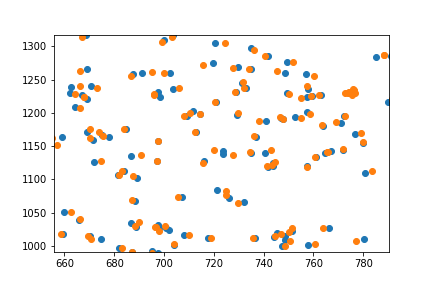

In [1415]:
plt.figure()
#keep = (zxys_750[:,2]>1024-100)&(zxys_750[:,2]<1024+100)
#plt.plot(zxys_750[keep,1],zxys_750[keep,0],'o')
#plt.plot(zxys_647[keep,1],zxys_647[keep,0],'o')
plt.plot(zxys_750[:,1],zxys_750[:,2],'o')
plt.plot(zxys_647[:,1],zxys_647[:,2],'o')
plt.show()